In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import sys
# append .. in folder connected
sys.path.append("..")

from WewerForecast.utils import fix_index_to_1h
from WewerForecast import TimeSeriesLSTMMLP

In [3]:
#  confoguration for wandb
run = wandb.init(
    project='Water-Demand-Forecasting',
    notes='Testing out wandb',
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christiaanwewer. Use `wandb login --relogin` to force relogin


In [4]:
            # lstm_historic_encoder_hidden_size,
            # num_historic_encoder_layers,
            # lstm_historic_encoder_dropout,
            # lstm_future_encoder_hidden_size,
            # num_future_encoder_layers,
            # lstm_future_encoder_dropout,
            # FNN_hidden_size,
            # FNN_layers,
            # FNN_dropout

wandb.config = {
    'model_name':'LSTMMLP_tests_1',
    'log_loss_interval':10,
    'save_path':r'model_saves',
    'save_model_interval':10,       
    'target_feature':'DMA A (L/s)',
    'include_historic_target':True,
    'historic_features':None,
    'future_features':['Air temperature (°C)',	'Air humidity (%)','Hour'],
    'scaler_dict' : {'DMA A (L/s)': 'normalization', 
                     'Air temperature (°C)': 'normalization', 
                     'Air humidity (%)': 'normalization', 
                     'Hour': 'normalization'},
    'historic_sequence_length':24,
    'prediction_horizon_length':24,
    'batch_size':32,
    'epochs':100,
    'learning_rate':0.001,
    'loss_function':'MultiQuantileLoss',
    'quantiles': [0.1, 0.5, 0.9],
    'masked_loss': False,
    'lstm_historic_encoder_hidden_size': 32,
    'num_historic_encoder_layers': 4,
    'lstm_historic_encoder_dropout': 0.1,
    'lstm_future_encoder_hidden_size': 32,
    'num_future_encoder_layers': 8,
    'lstm_future_encoder_dropout': 0.1,
    'FNN_hidden_size': 64,
    'FNN_layers': 2,
    'FNN_dropout': 0.1,
}

In [5]:
# load excel files from ../data/raw/WDSA into a pandas dataframe, col 0 Date-time CET-CEST (DD/MM/YYYY HH:mm)
df_inflow = pd.read_excel(r'../data/raw/WDSA/InflowData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')
df_weather = pd.read_excel(r'../data/raw/WDSA/WeatherData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')

# get latest start date of both datasets
start_date = max(df_inflow.dropna().index.min(), df_weather.dropna().index.min())

# get earliest end date of both datasets
end_date = min(df_inflow.dropna().index.max(), df_weather.dropna().index.max())

# get the intersection of both datasets
df_inflow = df_inflow.loc[start_date:end_date]
df_weather = df_weather.loc[start_date:end_date]

df_inflow = fix_index_to_1h(df_inflow)
df_weather = fix_index_to_1h(df_weather)

# add binary column to df_weather that indicates if it is weekend or midweek, make sure it is an integer
df_weather['IsWeekend'] = (df_weather.index.dayofweek > 4).astype(float)

# add hour of the day as a column to both dataframes
df_weather['Hour'] = df_weather.index.hour.astype(float)

# divide into first 75% training and 25% validation
divider = int(len(df_inflow) * 0.75)
df_inflow_train = df_inflow.iloc[:divider]
df_inflow_val = df_inflow.iloc[divider:]
df_weather_train = df_weather.iloc[:divider]
df_weather_val = df_weather.iloc[divider:]

# merge datasets
df_train = pd.merge(df_inflow_train, df_weather_train, left_index=True, right_index=True)
df_train = df_train.interpolate(method='linear')

df_val = pd.merge(df_inflow_val, df_weather_val, left_index=True, right_index=True)
df_val_interpolated = df_val.interpolate(method='linear')

In [6]:
# make TimeSeriesLSTM object with the configuration from wandb in one line
model = TimeSeriesLSTMMLP(
    df_train,
    df_val_interpolated,
    *list(wandb.config.values())
)



In [7]:
model.train()

Val loss: 0.4226160527197356
Epoch 1
-----
Train loss: 0.31259420737117327
Val loss: 0.2853638612732445

Epoch 2
-----


KeyboardInterrupt: 

In [8]:
model.load_model('model_saves/LSTMMLP_tests_1/LSTMMLP_tests_1_100_epochs.pt')

Loading model...
Model loaded


In [9]:
# predict 24*7 hours into the future
df_prediction_data = df_val_interpolated.iloc[1300:2800]
model.set_prediction_data(df_prediction_data)
df_prediction = model.predict(1) # just mse shape: [1,24,1]
# transform df_prediction back to original scale
df_truth = df_prediction_data.iloc[:2*24]

In [10]:
df_prediction

,Prediction 0.1th quantile DMA A (L/s),Prediction 0.5th quantile DMA A (L/s),Prediction 0.9th quantile DMA A (L/s)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,
2022-05-09 21:00:00,8.040298,8.040298,8.040298
2022-05-09 22:00:00,7.982943,7.982943,7.982943
2022-05-09 23:00:00,8.207273,8.207273,8.207273
2022-05-10 00:00:00,7.708221,7.708221,7.708221
2022-05-10 01:00:00,6.508999,6.508999,6.508999
2022-05-10 02:00:00,5.410242,5.410242,5.410242
2022-05-10 03:00:00,4.594063,4.594063,4.594063
2022-05-10 04:00:00,4.143835,4.143835,4.143835
2022-05-10 05:00:00,4.101660,4.101660,4.101660


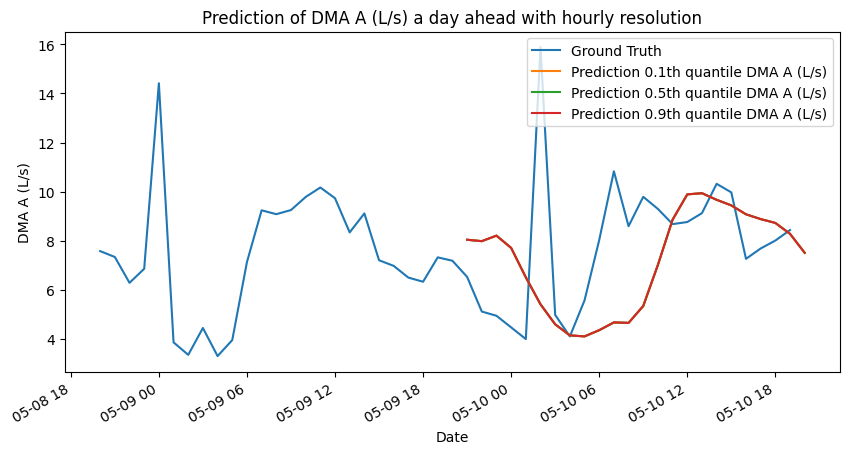

In [11]:
# plot prediction along with prediction data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_truth.index, df_truth['DMA A (L/s)'], label='Ground Truth')
alpha = [0.5, 1, 0.5]
df_prediction.plot(ax=ax)
# for i, quantile in enumerate(wandb.config['quantiles']):
#     df_prediction[f'Prediction {quantile}th quantile DMA A (L/s)'].plot(
#         ax=ax, 
#         color= 'red',
#         alpha=alpha[i],
#         label=f'{quantile}th quantile'
    # )
ax.set_xlabel('Date')
ax.set_ylabel('DMA A (L/s)')
ax.legend()
ax.set_title('Prediction of DMA A (L/s) a day ahead with hourly resolution')
plt.show()



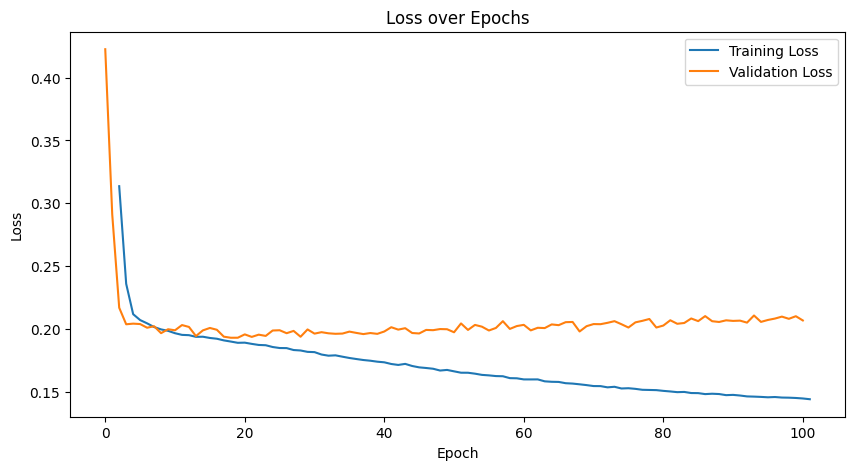

In [15]:
# plot loss over epochs
# note that the first validation loss is an untrained loss and thus trained before the first epoch
# the first training loss is the loss after the first epoch
# model.train_losses
# model.val_losses

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, len(model.train_losses)+1), model.train_losses, label='Training Loss')
ax.plot(np.arange(0, len(model.val_losses)),model.val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss over Epochs')
plt.show()

